## Import Libraries


In [93]:
import numpy as np
import seaborn as sns
import pickle
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## My function

In [94]:
## memory optimisation 
def reduce_mem_usage(df, cat_cols=[]):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col in cat_cols:
            df[col] = df[col].astype('category')

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    return df

In [95]:
#convert object columns to category (with see memory_usage - for control)
def convert_columns_to_catg(df, cat_cols):
    for col in cat_cols:
        print("converting", col.ljust(30), "size: ", round(df[col].memory_usage(deep=True)*1e-6,2), end="\t")
        df[col] = df[col].astype("category")
        print("->\t", round(df[col].memory_usage(deep=True)*1e-6,2))

In [96]:
##function NaN values in persent%
def missing_values(df):
  missing_values = round(((df.isna().sum() / len(df)) * 100).sort_values(ascending=False), 2)
  return missing_values

### HANDLING MISSING VALUES

In [ ]:
# #read data
df = pd.read_csv('../data/df_with_target.csv')
print(df.shape)
df.head(5)

##### step 1

In [124]:
#drop device_model, becouse it is almost emty
df.drop(columns = ['device_model'], inplace = True)

In [125]:
print(df.shape)
missing_values(df)

(1898195, 18)


event_action                95.34
utm_keyword                 58.31
device_os                   57.68
device_brand                19.83
utm_adcontent               18.14
utm_campaign                11.97
utm_source                   0.06
visit_date                   0.06
visit_time                   0.06
visit_number                 0.06
utm_medium                   0.06
client_id                    0.06
device_category              0.06
device_screen_resolution     0.06
device_browser               0.06
geo_country                  0.06
geo_city                     0.06
session_id                   0.00
dtype: float64

In [126]:
#Creating list of columns with too little missing values
cols_for_dropna = ['utm_source', 'visit_time', 'visit_number', 'utm_medium', 'client_id', 'device_category', 'visit_date', 'device_screen_resolution', 'device_browser', 'geo_country', 'geo_city']

In [127]:
# Drop some rows with Na. Because too little missing values
df.dropna(subset = cols_for_dropna, inplace = True)

In [128]:
#view shape
df.shape

(1897005, 18)

In [129]:
#view values from target column
df.event_action.value_counts(dropna=False)

event_action
NaN                                 1809636
sub_car_claim_click                   31709
sub_open_dialog_click                 19843
sub_submit_success                    15888
sub_car_claim_submit_click            11070
sub_call_number_click                  3304
sub_callback_submit_click              2647
sub_car_request_submit_click           2374
sub_custom_question_submit_click        534
Name: count, dtype: int64

In [130]:
#Replace Nan to 0, target events to 1
df.event_action = df.event_action.apply(lambda x: 0 if x is np.nan else 1)
df.sample(5)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
374271,2398024828768194148.1632351326.1632351326,558333664.1632341,2021-09-23,01:00:00,2.0,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Oukitel,360x640,Opera,Russia,Moscow,0
981503,5053449506974455079.1637209387.1637209387,1176597901.163721,2021-11-18,07:23:07,1.0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Samsung,412x892,Chrome,Russia,Norilsk,0
1461004,7153038789238148286.1629572287.1629572287,1665446625.162957,2021-08-21,21:00:00,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Google,393x851,Chrome,Russia,Moscow,0
900696,4701409677879574455.1637384118.1637384118,1094632241.163738,2021-11-20,07:55:18,1.0,ZpYIoDJMcFzVoPFsHGJL,smartbanner,jqlUOdZBNZYfInQVcZlS,qhEmhjPXvwgEHdBikgEQ,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,390x844,Safari,Russia,Moscow,0
1149761,578865935614350292.1625206849.1625206849,134777728.162517,2021-07-02,09:00:00,2.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,NaN,Apple,414x896,Safari,Russia,Saint Petersburg,0


In [131]:
#See result
df.event_action.value_counts(dropna=False)

event_action
0    1809636
1      87369
Name: count, dtype: int64

##### step 2

In [152]:
df = df_copy.copy()
#view missing_values in other columns
print(df.shape)
missing_values(df)

(1897005, 18)


utm_keyword                 58.29
device_os                   57.66
device_brand                19.78
utm_adcontent               18.10
utm_campaign                11.92
device_category              0.00
geo_city                     0.00
geo_country                  0.00
device_browser               0.00
device_screen_resolution     0.00
session_id                   0.00
client_id                    0.00
utm_medium                   0.00
utm_source                   0.00
visit_number                 0.00
visit_time                   0.00
visit_date                   0.00
event_action                 0.00
dtype: float64

##### utm_campaign

In [153]:
df.utm_campaign.value_counts(normalize=True, dropna=False).mul(100).round(2)

utm_campaign
LTuZkdKfxRGVceoWkVyg    25.11
LEoPHuyFvzoNfnzGgfcd    17.46
FTjNLDyTrXaWYgZymFkV    13.06
NaN                     11.92
gecBYcKZCPMcVYdSSzKP     7.27
                        ...  
cqgnjDbqrtCipVvzhxqa     0.00
AdtHYglxfCpTpwZeTAuW     0.00
pcvPxfVFaAmhwFmvIeYd     0.00
qPDTdivQVeflLjTYIJnG     0.00
cXxuwXPoQCvAXPHpFcZl     0.00
Name: proportion, Length: 413, dtype: float64

In [154]:
df.utm_campaign.nunique()

412

<Axes: xlabel='utm_campaign', ylabel='Count'>

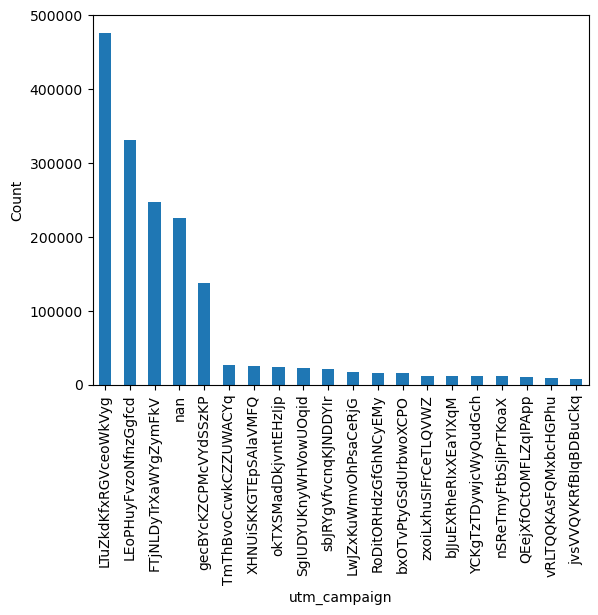

In [155]:
df['utm_campaign'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='utm_campaign', ylabel='Count', rot=90)

In [156]:
#Top 20 value_counts from utm_campaign
df.utm_campaign.value_counts().head(20)

utm_campaign
LTuZkdKfxRGVceoWkVyg    476407
LEoPHuyFvzoNfnzGgfcd    331162
FTjNLDyTrXaWYgZymFkV    247825
gecBYcKZCPMcVYdSSzKP    137928
TmThBvoCcwkCZZUWACYq     26697
XHNUiSKKGTEpSAlaVMFQ     24883
okTXSMadDkjvntEHzIjp     24549
SgIUDYUKnyWHVowUOqid     23180
sbJRYgVfvcnqKJNDDYIr     20752
LwJZxKuWmvOhPsaCeRjG     17839
RoDitORHdzGfGhNCyEMy     15856
bxOTvPtyGSdUrbwoXCPO     15504
zxoiLxhuSIFrCeTLQVWZ     12578
bJJuEXRheRIxXEaYIXqM     12353
YCKgTzTDywjcWyQudGch     12227
nSReTmyFtbSjlPrTKoaX     11778
QEejXfOCtOMFLZqIPApp     10209
vRLTQQKAsFQMxbcHGPhu      9517
jvsVVQVKRfBIqBDBuCkq      8033
eimRuUrNhZLAYcwRrNXu      7937
Name: count, dtype: int64

In [157]:
# I have no idea. Fill "other"
df.utm_campaign.fillna('other', inplace = True)

In [158]:
#view top 20
df.utm_campaign.value_counts(normalize=True, dropna=False).mul(100).round(1).head(20).index.tolist()

['LTuZkdKfxRGVceoWkVyg',
 'LEoPHuyFvzoNfnzGgfcd',
 'FTjNLDyTrXaWYgZymFkV',
 'other',
 'gecBYcKZCPMcVYdSSzKP',
 'TmThBvoCcwkCZZUWACYq',
 'XHNUiSKKGTEpSAlaVMFQ',
 'okTXSMadDkjvntEHzIjp',
 'SgIUDYUKnyWHVowUOqid',
 'sbJRYgVfvcnqKJNDDYIr',
 'LwJZxKuWmvOhPsaCeRjG',
 'RoDitORHdzGfGhNCyEMy',
 'bxOTvPtyGSdUrbwoXCPO',
 'zxoiLxhuSIFrCeTLQVWZ',
 'bJJuEXRheRIxXEaYIXqM',
 'YCKgTzTDywjcWyQudGch',
 'nSReTmyFtbSjlPrTKoaX',
 'QEejXfOCtOMFLZqIPApp',
 'vRLTQQKAsFQMxbcHGPhu',
 'jvsVVQVKRfBIqBDBuCkq']

In [159]:
# Creating list top 20
columns_utm_campaign_for_save = ['LTuZkdKfxRGVceoWkVyg',
 'LEoPHuyFvzoNfnzGgfcd',
 'FTjNLDyTrXaWYgZymFkV',
 'other',
 'gecBYcKZCPMcVYdSSzKP',
 'TmThBvoCcwkCZZUWACYq',
 'XHNUiSKKGTEpSAlaVMFQ',
 'okTXSMadDkjvntEHzIjp',
 'SgIUDYUKnyWHVowUOqid',
 'sbJRYgVfvcnqKJNDDYIr',
 'LwJZxKuWmvOhPsaCeRjG',
 'RoDitORHdzGfGhNCyEMy',
 'bxOTvPtyGSdUrbwoXCPO',
 'zxoiLxhuSIFrCeTLQVWZ',
 'bJJuEXRheRIxXEaYIXqM',
 'YCKgTzTDywjcWyQudGch',
 'nSReTmyFtbSjlPrTKoaX',
 'QEejXfOCtOMFLZqIPApp',
 'vRLTQQKAsFQMxbcHGPhu',
 'jvsVVQVKRfBIqBDBuCkq']

In [160]:
# Replace value not include top 20 to 'other'
df.utm_campaign = df.utm_campaign.apply(lambda x: x if x in columns_utm_campaign_for_save else 'other1')

##### utm_keyword

In [161]:
df.utm_keyword.value_counts(normalize=True, dropna=False).mul(100).round(2)

utm_keyword
NaN                     58.29
puhZPIYqKXeFPaUviSjo    27.22
aXQzDWsJuGXeBXexNHjc     1.28
pHqgLcdBQPSLcrTpLkdr     0.73
ITfrGJNwVsHBGJMAKoct     0.72
                        ...  
uucOIlRysdLPcqDPWItw     0.00
SVgtRXtJAnTJGHMmQaSp     0.00
lGmMXrMkjZsdbfpkENcb     0.00
eEEwicXmITPUhtBeyybE     0.00
fcXWTQaKfxbkBkBnzLhK     0.00
Name: proportion, Length: 1220, dtype: float64

<Axes: xlabel='utm_campaign', ylabel='Count'>

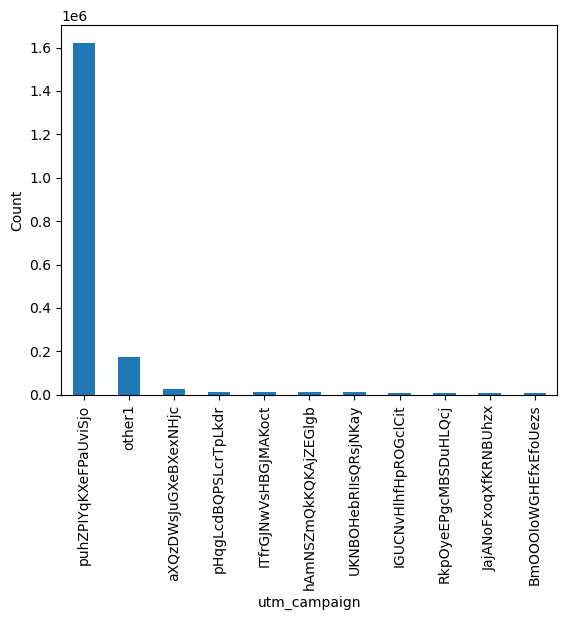

In [167]:
df['utm_keyword'].value_counts(dropna=False).head(15).plot(kind='bar', xlabel='utm_campaign', ylabel='Count', rot=90)

In [163]:
#replace Nan most freq values
df.utm_keyword.fillna('puhZPIYqKXeFPaUviSjo', inplace = True)

In [164]:
df.utm_keyword.value_counts(normalize=True, dropna=False).mul(100).round(1).head(10).index.tolist()

['puhZPIYqKXeFPaUviSjo',
 'aXQzDWsJuGXeBXexNHjc',
 'pHqgLcdBQPSLcrTpLkdr',
 'ITfrGJNwVsHBGJMAKoct',
 'hAmNSZmQkKQKAjZEGlgb',
 'UKNBOHebRIIsQRsjNKay',
 'IGUCNvHlhfHpROGclCit',
 'RkpOyeEPgcMBSDuHLQcj',
 'JajANoFxoqXfKRNBUhzx',
 'BmOOOIoWGHEfxEfoUezs']

In [165]:
columns_utm_keyword_for_save = ['puhZPIYqKXeFPaUviSjo',
 'aXQzDWsJuGXeBXexNHjc',
 'pHqgLcdBQPSLcrTpLkdr',
 'ITfrGJNwVsHBGJMAKoct',
 'hAmNSZmQkKQKAjZEGlgb',
 'UKNBOHebRIIsQRsjNKay',
 'IGUCNvHlhfHpROGclCit',
 'RkpOyeEPgcMBSDuHLQcj',
 'JajANoFxoqXfKRNBUhzx',
 'BmOOOIoWGHEfxEfoUezs']

In [166]:
df.utm_keyword = df.utm_keyword.apply(lambda x: x if x in columns_utm_keyword_for_save else 'other1')

In [151]:
missing_values(df)

device_os                   57.66
device_brand                19.78
utm_adcontent               18.10
session_id                   0.00
device_category              0.00
geo_city                     0.00
geo_country                  0.00
device_browser               0.00
device_screen_resolution     0.00
utm_keyword                  0.00
client_id                    0.00
utm_campaign                 0.00
utm_medium                   0.00
utm_source                   0.00
visit_number                 0.00
visit_time                   0.00
visit_date                   0.00
event_action                 0.00
dtype: float64

##### device_brand & device_os


In [168]:
df.device_brand.value_counts(normalize=True, dropna=False).mul(100).round(2)

device_brand
Apple       29.66
NaN         19.78
Samsung     17.90
Xiaomi      15.45
Huawei       9.96
            ...  
Cube         0.00
Wexler       0.00
Smarteo      0.00
KingSing     0.00
Opera        0.00
Name: proportion, Length: 206, dtype: float64

<Axes: xlabel='device_brand', ylabel='Count'>

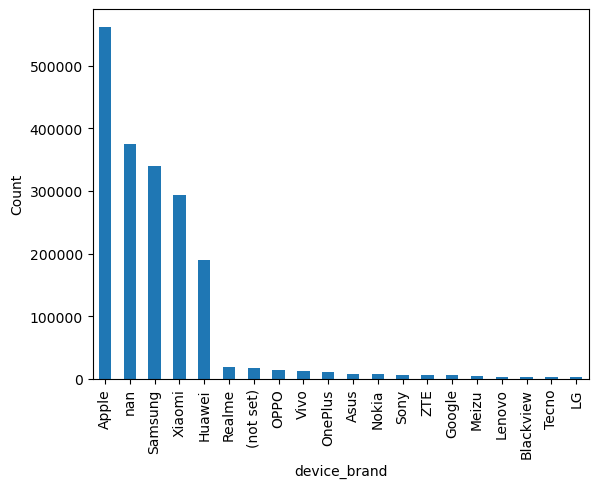

In [169]:
df['device_brand'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='device_brand', ylabel='Count', rot=90)

In [170]:
df.device_brand.nunique()

205

In [172]:
df.device_os.value_counts(normalize=True, dropna=False).mul(100).round(2)

device_os
NaN              57.66
Android          24.85
iOS              11.12
Windows           4.72
Macintosh         1.35
Linux             0.27
(not set)         0.02
Chrome OS         0.00
BlackBerry        0.00
Tizen             0.00
Samsung           0.00
Windows Phone     0.00
Firefox OS        0.00
Nokia             0.00
Name: proportion, dtype: float64

<Axes: xlabel='device_os', ylabel='Count'>

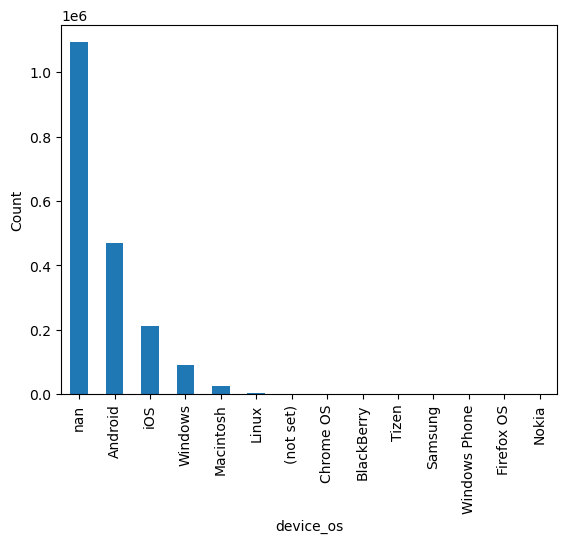

In [173]:
df['device_os'].value_counts(dropna=False).plot(kind='bar', xlabel='device_os', ylabel='Count', rot=90)

In [174]:
df.device_os.nunique()

13

In [175]:
#Apple
df.loc[(df.device_brand == 'Apple')].device_os.value_counts(dropna=False)

device_os
NaN    351743
iOS    210865
Name: count, dtype: int64

In [176]:
#Fill Na in device_os the Apple brand
df['device_os'] = df['device_os'].mask((df.device_brand == 'Apple'), 'iOS')

In [177]:
#View devises with 'iOS' operating system. In result - only Apple
df.loc[(df.device_os == 'iOS')].device_brand.value_counts(dropna=False)

device_brand
Apple        562608
(not set)         6
Name: count, dtype: int64

In [179]:
# replace to Apple from iOS system
df['device_brand'] = df['device_brand'].mask((df.device_os == 'iOS'), 'Apple')

In [180]:
#View Samsung os
df.loc[(df.device_brand == 'Samsung')].device_os.value_counts(dropna=False)

device_os
NaN        170780
Android    168824
Samsung         4
Name: count, dtype: int64

In [181]:
#Fill Na in device_os the Samsung brand
df['device_os'] = df['device_os'].mask((df.device_brand == 'Samsung'), 'Android')

In [182]:
#Xiaomi
df.loc[(df.device_brand == 'Xiaomi')].device_os.value_counts(dropna=False)

device_os
NaN        149794
Android    143213
Name: count, dtype: int64

In [183]:
#Fill Na in device_os the Xiaomi brand
df['device_os'] = df['device_os'].mask((df.device_brand == 'Xiaomi'), 'Android')

In [184]:
#Huawei
df.loc[(df.device_brand == 'Huawei')].device_os.value_counts(dropna=False)

device_os
NaN        98078
Android    90882
Name: count, dtype: int64

In [185]:
#Fill Na in device_os the Huawei brand
df['device_os'] = df['device_os'].mask((df.device_brand == 'Huawei'), 'Android')

In [188]:
#see top 10 of device_os
df.device_os.value_counts(normalize=True, dropna=False).mul(100).round(2).head(10)

device_os
Android       46.92
iOS           29.66
NaN           17.04
Windows        4.72
Macintosh      1.35
Linux          0.27
(not set)      0.02
Chrome OS      0.00
BlackBerry     0.00
Tizen          0.00
Name: proportion, dtype: float64

In [189]:
#see top 10 of device_brand
df.device_brand.value_counts(normalize=True, dropna=False).mul(100).round(2).head(10)

device_brand
Apple        29.66
NaN          19.78
Samsung      17.90
Xiaomi       15.45
Huawei        9.96
Realme        1.02
(not set)     0.94
OPPO          0.73
Vivo          0.63
OnePlus       0.53
Name: proportion, dtype: float64

In [190]:
#так как остальные брэнды занимают меньше 10%, и скорее, всего у большинства оставшися Андроид. Заполним им.
# Fill remains
df['device_os'].fillna('Android', inplace=True)

In [191]:
# View remains Na from device_brand. Think)
df.loc[df.device_brand.isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
28,9055505230298952295.1638478433.1638478433,2108399111.163848,2021-12-02,23:53:53,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,1536x864,Chrome,Russia,Balashikha,0
63,9055657327967035032.1629707931.1629707931,2108434524.162971,2021-08-23,11:00:00,1.0,nSReTmyFtbSjlPrTKoaX,banner,other1,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Android,NaN,1920x1080,YaBrowser,Russia,Moscow,0
64,905565977351442956.1622561294.1622561294,210843509.162256,2021-06-01,18:00:00,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Android,NaN,1920x1080,Chrome,Russia,Moscow,0
67,9055678214400253418.1636965866.1636965866,2108439387.163696,2021-11-15,11:44:26,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Windows,NaN,1920x1080,Chrome,Russia,Saint Petersburg,0
73,9055788191321875859.1626006934.1626006934,2108464993.162601,2021-07-11,15:00:00,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Android,NaN,1280x720,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897090,9055354507009984602.1636829278.1636829278,2108364018.163683,2021-11-13,21:47:58,1.0,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,aXQzDWsJuGXeBXexNHjc,desktop,Windows,NaN,1366x768,Firefox,Russia,Balashikha,0
1897092,9055363711117247375.1629176721.1629176721,2108366161.162918,2021-08-17,08:00:00,1.0,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,puhZPIYqKXeFPaUviSjo,desktop,Android,NaN,1920x1080,Chrome,Russia,(not set),0
1897094,9055376699099939975.1630766214.1630766214,2108369185.163077,2021-09-04,17:00:00,1.0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,desktop,Android,NaN,1920x1080,Chrome,Russia,Khimki,1
1897102,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,10:48:25,1.0,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,other1,desktop,Windows,NaN,1920x1080,Chrome,Russia,Moscow,0


In [200]:
#View value_counts of device_browser
df.device_browser.value_counts()

device_browser
Chrome                              1033193
Safari                               489153
YaBrowser                            136271
Safari (in-app)                       70662
Android Webview                       56506
Samsung Internet                      47982
Opera                                 27138
Firefox                               16965
Edge                                  16453
UC Browser                              878
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
MRCHROME                                 77
Android Browser                          49
Puffin                                   46
Opera Mini                               45
Internet Explorer                        36
Maxthon                                  32
Android                                  22
Instagram 216.1.0

In [201]:
#View top 10 device_brand
df.device_brand.value_counts(dropna=False).head(10)

device_brand
Apple        562614
NaN          375251
Samsung      339608
Xiaomi       293007
Huawei       188960
Realme        19389
(not set)     17883
OPPO          13802
Vivo          11996
OnePlus       10051
Name: count, dtype: int64

In [202]:
#View what kind of device_browser use in the Apple
df.loc[(df.device_brand == 'Apple')].device_browser.value_counts(dropna=False)

device_browser
Safari                      447178
Safari (in-app)              70662
Chrome                       26632
YaBrowser                    18042
Instagram 202.0.0.23.119        17
Instagram 216.0.0.12.135        17
UC Browser                      16
Instagram 207.0.0.28.118        14
Instagram 192.0.0.37.119         7
Instagram 203.0.0.26.117         6
Instagram 213.0.0.19.117         6
Instagram 201.0.0.23.111         5
Instagram 208.0.0.26.131         5
MyApp                            2
Instagram 199.0.0.27.120         2
Iron                             2
Edge                             1
Name: count, dtype: int64

In [203]:
df.loc[(df.device_brand == 'Apple')].device_browser.unique()

array(['Safari', 'Safari (in-app)', 'Chrome', 'YaBrowser',
       'Instagram 202.0.0.23.119', 'UC Browser',
       'Instagram 207.0.0.28.118', 'Instagram 216.0.0.12.135',
       'Instagram 192.0.0.37.119', 'Edge', 'MyApp',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 208.0.0.26.131', 'Instagram 199.0.0.27.120',
       'Instagram 213.0.0.19.117', 'Iron'], dtype=object)

In [204]:
df.device_browser.unique()

array(['Chrome', 'Samsung Internet', 'Safari', 'YaBrowser',
       'Android Webview', 'Safari (in-app)', 'Opera', 'Firefox', 'Edge',
       'helloworld', 'Instagram 208.0.0.32.135 Android',
       'Instagram 209.0.0.21.119 Android', 'Android Runtime',
       'UC Browser', 'Mozilla Compatible Agent', '(not set)', 'Mozilla',
       'Opera Mini', 'Coc Coc', 'Instagram 213.0.0.29.120 Android',
       'Android', 'Instagram 216.1.0.21.137 Android', '[FBAN',
       'Internet Explorer', 'Puffin', 'MRCHROME', 'com.vk.vkclient',
       'Instagram 202.0.0.23.119', 'Android Browser', 'Maxthon',
       'Instagram 207.0.0.28.118', 'Instagram 216.0.0.12.135',
       'Instagram 199.1.0.34.119 Android', 'Instagram 192.0.0.37.119',
       'Amazon Silk', 'SeaMonkey', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android', 'MyApp', 'NetFront',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 An

In [205]:
# Creating list of Apple's device browsers
list_apple_browser = ['Safari', 'Safari (in-app)', 'Edge', 'UC Browser','Instagram 208.0.0.32.135 Android', 'Instagram 209.0.0.21.119 Android',
       'Instagram 213.0.0.29.120 Android', 'Instagram 216.1.0.21.137 Android', 'Instagram 202.0.0.23.119',
       'Instagram 207.0.0.28.118', 'Instagram 216.0.0.12.135',
       'Instagram 199.1.0.34.119 Android', 'Instagram 192.0.0.37.119', 'Instagram 194.0.0.36.172 Android',
       'Instagram 202.0.0.37.123 Android',
       'Instagram 201.0.0.23.111', 'Instagram 203.0.0.26.117',
       'Instagram 192.0.0.35.123 Android',
       'Instagram 212.0.0.38.119 Android', 'Instagram 208.0.0.26.131',
      'Instagram 199.0.0.27.120',
       'Instagram 158.0.0.30.123 Android',
       'Instagram 206.1.0.34.121 Android',
       'Instagram 213.0.0.19.117' ]

In [206]:
#Fill Na in the Apple
df['device_brand'] = df['device_brand'].mask((df.device_browser.isin(list_apple_browser)), 'Apple')

In [207]:
#Fill Na in the Samsung. (device_browser = Samsung Internet)
df['device_brand'] = df['device_brand'].mask((df.device_browser == 'Samsung Internet'), 'Samsung')

In [208]:
# I don't now what else to do. Replace remainds "Other" values
df['device_brand'].fillna('Other', inplace = True)

In [209]:
print(df.shape)
missing_values(df)

(1897005, 18)


utm_adcontent               18.1
session_id                   0.0
device_category              0.0
geo_city                     0.0
geo_country                  0.0
device_browser               0.0
device_screen_resolution     0.0
device_brand                 0.0
device_os                    0.0
utm_keyword                  0.0
client_id                    0.0
utm_campaign                 0.0
utm_medium                   0.0
utm_source                   0.0
visit_number                 0.0
visit_time                   0.0
visit_date                   0.0
event_action                 0.0
dtype: float64

In [214]:
df.device_brand.value_counts(normalize=True, dropna=False).mul(100).round(2).head(25)

device_brand
Apple      32.80
Samsung    17.94
Other      16.67
Xiaomi     15.43
Huawei      9.94
other1      6.20
Realme      1.02
Name: proportion, dtype: float64

In [211]:
columns_device_brand_for_save = ['Apple',
 'Samsung',
 'Other',
 'Xiaomi',
 'Huawei',
 'Realme']

In [213]:
df.device_brand = df.device_brand.apply(lambda x: x if x in columns_device_brand_for_save else 'other1')

In [215]:
df.device_os.value_counts(normalize=True, dropna=False).mul(100).round(2)

device_os
Android          63.96
iOS              29.66
Windows           4.72
Macintosh         1.35
Linux             0.27
(not set)         0.02
Chrome OS         0.00
BlackBerry        0.00
Tizen             0.00
Windows Phone     0.00
Firefox OS        0.00
Nokia             0.00
Name: proportion, dtype: float64

In [217]:
df.device_os.value_counts(normalize=True, dropna=False).index.to_list()

['Android',
 'iOS',
 'Windows',
 'Macintosh',
 'Linux',
 '(not set)',
 'Chrome OS',
 'BlackBerry',
 'Tizen',
 'Windows Phone',
 'Firefox OS',
 'Nokia']

In [219]:
columns_device_os_for_save = ['Android',
 'iOS',
 'Windows',
 'Macintosh',
 'Linux']

In [220]:
df.device_os = df.device_os.apply(lambda x: x if x in columns_device_os_for_save else 'other1')

##### device_browser

In [221]:
df.device_browser.value_counts(normalize=True, dropna=False).mul(100).round(1).head(15)

device_browser
Chrome                              54.5
Safari                              25.8
YaBrowser                            7.2
Safari (in-app)                      3.7
Android Webview                      3.0
Samsung Internet                     2.5
Opera                                1.4
Firefox                              0.9
Edge                                 0.9
UC Browser                           0.0
Android Runtime                      0.0
Mozilla Compatible Agent             0.0
[FBAN                                0.0
Instagram 208.0.0.32.135 Android     0.0
Instagram 209.0.0.21.119 Android     0.0
Name: proportion, dtype: float64

<Axes: xlabel='device_browser', ylabel='Count'>

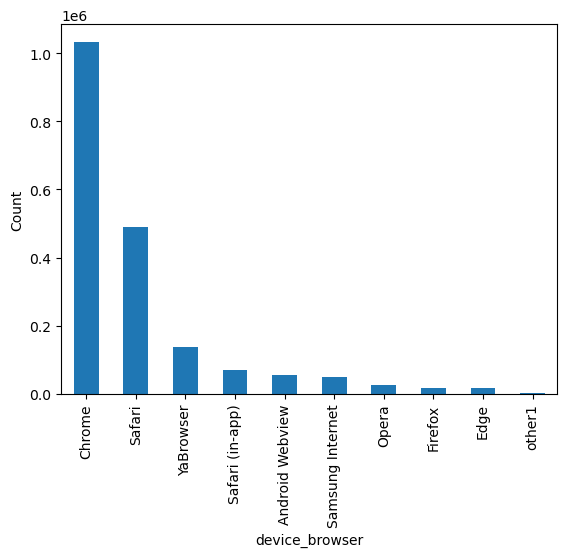

In [226]:
df['device_browser'].value_counts(dropna=False).head(15).plot(kind='bar', xlabel='device_browser', ylabel='Count', rot=90)

In [223]:
df.device_browser.value_counts(normalize=True, dropna=False).head(9).index.tolist()

['Chrome',
 'Safari',
 'YaBrowser',
 'Safari (in-app)',
 'Android Webview',
 'Samsung Internet',
 'Opera',
 'Firefox',
 'Edge']

In [224]:
columns_device_browser_for_save = ['Chrome',
 'Safari',
 'YaBrowser',
 'Safari (in-app)',
 'Android Webview',
 'Samsung Internet',
 'Opera',
 'Firefox',
 'Edge']

In [225]:
df.device_browser = df.device_browser.apply(lambda x: x if x in columns_device_browser_for_save else 'other1')

##### geo_country

In [227]:
df.geo_country.value_counts(normalize=True, dropna=False).mul(100).round(1).head(15)

geo_country
Russia                  1836945
United States             11823
Ukraine                    9137
Ireland                    4034
Belarus                    3660
Sweden                     2708
Kazakhstan                 2308
Germany                    2288
Turkey                     1992
Netherlands                1566
Uzbekistan                 1535
United Kingdom             1483
(not set)                  1151
Kyrgyzstan                  988
Georgia                     957
France                      807
Cyprus                      777
Armenia                     696
Finland                     648
Spain                       606
Poland                      562
United Arab Emirates        480
Israel                      435
Tajikistan                  404
Moldova                     385
Latvia                      357
Italy                       356
Azerbaijan                  332
Egypt                       331
Greece                      313
Name: count, dtype: int64

<Axes: xlabel='geo_country', ylabel='Count'>

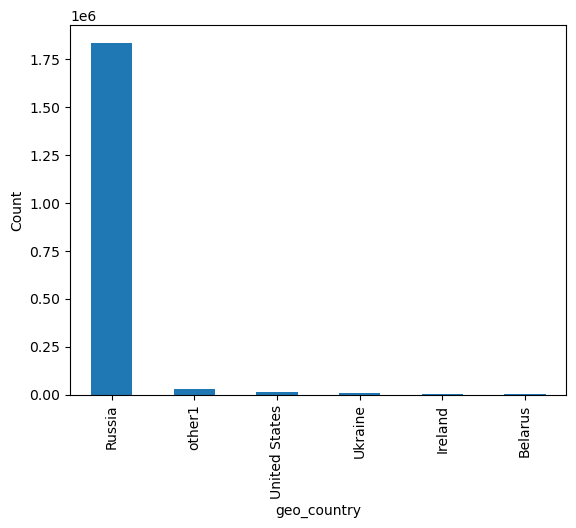

In [232]:
df['geo_country'].value_counts(dropna=False).head(15).plot(kind='bar', xlabel='geo_country', ylabel='Count', rot=90)

In [229]:
df.geo_country.value_counts(normalize=True, dropna=False).head(5).index.tolist()

['Russia', 'United States', 'Ukraine', 'Ireland', 'Belarus']

In [230]:
columns_geo_country_for_save = ['Russia', 'United States', 'Ukraine','Ireland', 'Belarus']

In [231]:
df.geo_country = df.geo_country.apply(lambda x: x if x in columns_geo_country_for_save else 'other1')

#### geo_city

In [237]:
df.geo_city.value_counts(normalize=True, dropna=False).mul(100).round(1).head(25)

geo_city
Moscow              43.4
Saint Petersburg    15.9
(not set)            4.2
Yekaterinburg        1.9
Krasnodar            1.7
Kazan                1.6
Samara               1.3
Nizhny Novgorod      1.2
Ufa                  1.2
Novosibirsk          1.2
Krasnoyarsk          0.9
Chelyabinsk          0.9
Tula                 0.9
Rostov-on-Don        0.7
Voronezh             0.7
Irkutsk              0.7
Grozny               0.7
Balashikha           0.7
Vladivostok          0.7
Yaroslavl            0.5
Sochi                0.5
Tyumen               0.5
Khimki               0.4
Saratov              0.4
Perm                 0.3
Name: proportion, dtype: float64

<Axes: xlabel='geo_city', ylabel='Count'>

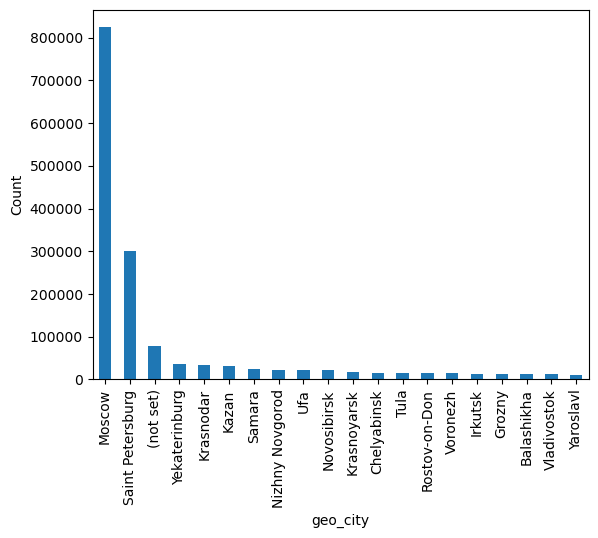

In [238]:
df['geo_city'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='geo_city', ylabel='Count', rot=90)

In [240]:
df.geo_city.value_counts(normalize=True, dropna=False).head(20).index.tolist()

['Moscow',
 'Saint Petersburg',
 '(not set)',
 'Yekaterinburg',
 'Krasnodar',
 'Kazan',
 'Samara',
 'Nizhny Novgorod',
 'Ufa',
 'Novosibirsk',
 'Krasnoyarsk',
 'Chelyabinsk',
 'Tula',
 'Rostov-on-Don',
 'Voronezh',
 'Irkutsk',
 'Grozny',
 'Balashikha',
 'Vladivostok',
 'Yaroslavl']

In [241]:
columns_geo_city_for_save = ['Moscow',
 'Saint Petersburg',
 '(not set)',
 'Yekaterinburg',
 'Krasnodar',
 'Kazan',
 'Samara',
 'Nizhny Novgorod',
 'Ufa',
 'Novosibirsk',
 'Krasnoyarsk',
 'Chelyabinsk',
 'Tula',
 'Rostov-on-Don',
 'Voronezh',
 'Irkutsk',
 'Grozny',
 'Balashikha',
 'Vladivostok',
 'Yaroslavl']

In [242]:
df.geo_city = df.geo_city.apply(lambda x: x if x in columns_geo_city_for_save else 'other1')

##### utm_adcontent

In [244]:
#Top 10 value_counts from utm_adcontent
df.utm_adcontent.value_counts(normalize=True, dropna=False).mul(100).round(1).head(25)

utm_adcontent
JNHcPlZPxEMWDnRiyoBf    54.4
NaN                     18.1
vCIpmpaGBnIQhyYNkXqp     9.7
xhoenQgDQsgfEPYNPwKO     6.0
PkybGvWbaqORmxjNunqZ     3.2
LLfCasrxQzJIyuldcuWy     1.3
TuyPWsGQruPMpKvRxeBF     1.0
UxrnyMlRBSOhOjytXnMG     0.7
dUuXlWzvmhDSyclWRhNP     0.5
yYdBRbPmBMUZHXwqGxNx     0.5
WYLajZgbUhGimwBKDZUH     0.5
SOkCdPxfUcZUzzOdgGES     0.4
AdeErYgVTbRcAWtHrMHq     0.3
nNqUcgFgcqQbTVSvgaHr     0.3
aYAcKhelKzYpXrRYknSP     0.3
XSkXBCPfnJjvxbfeewtd     0.2
XKsYZiUFcdkUXQpoLKyS     0.2
FkiRXDLOWtzVfvhEkhNo     0.2
xnyHaukLtAvgViiZSyBC     0.1
SAVVWaMghGnnvPOqMOIt     0.1
guyNoEvzgofQvvwExGOq     0.1
LcGIUNPUAmXtQJaDfFBR     0.1
qhEmhjPXvwgEHdBikgEQ     0.1
sYzBROYhjSDbFZCpzGyf     0.1
NhvfEqcSTGEZKxxvUZlj     0.1
Name: proportion, dtype: float64

<Axes: xlabel='utm_adcontent', ylabel='Count'>

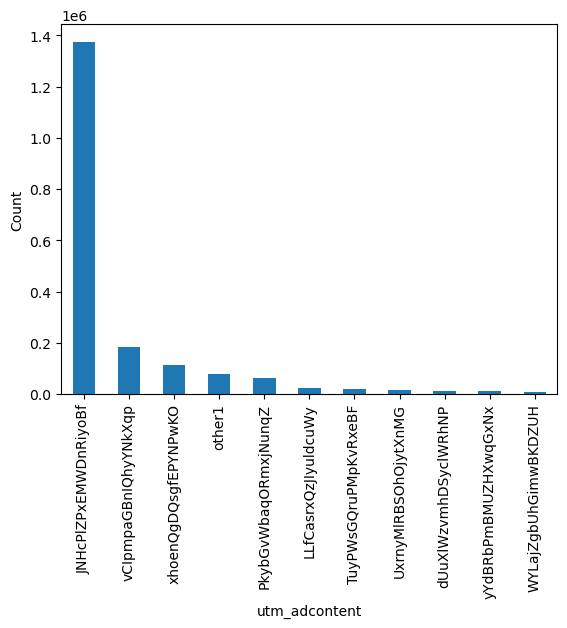

In [250]:
df['utm_adcontent'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='utm_adcontent', ylabel='Count', rot=90)

In [246]:
#Fill Na freq meaning
df.utm_adcontent.fillna('JNHcPlZPxEMWDnRiyoBf', inplace = True)

In [247]:
df.utm_adcontent.value_counts(normalize=True, dropna=False).head(10).index.tolist()

['JNHcPlZPxEMWDnRiyoBf',
 'vCIpmpaGBnIQhyYNkXqp',
 'xhoenQgDQsgfEPYNPwKO',
 'PkybGvWbaqORmxjNunqZ',
 'LLfCasrxQzJIyuldcuWy',
 'TuyPWsGQruPMpKvRxeBF',
 'UxrnyMlRBSOhOjytXnMG',
 'dUuXlWzvmhDSyclWRhNP',
 'yYdBRbPmBMUZHXwqGxNx',
 'WYLajZgbUhGimwBKDZUH']

In [248]:
columns_utm_adcontent_for_save = ['JNHcPlZPxEMWDnRiyoBf',
 'vCIpmpaGBnIQhyYNkXqp',
 'xhoenQgDQsgfEPYNPwKO',
 'PkybGvWbaqORmxjNunqZ',
 'LLfCasrxQzJIyuldcuWy',
 'TuyPWsGQruPMpKvRxeBF',
 'UxrnyMlRBSOhOjytXnMG',
 'dUuXlWzvmhDSyclWRhNP',
 'yYdBRbPmBMUZHXwqGxNx',
 'WYLajZgbUhGimwBKDZUH']

In [249]:
df.utm_adcontent = df.utm_adcontent.apply(lambda x: x if x in columns_utm_adcontent_for_save else 'other1')

#### utm_source

In [251]:
df.utm_source.value_counts(normalize=True, dropna=False).mul(100).round(2).head(20)

utm_source
ZpYIoDJMcFzVoPFsHGJL    31.16
fDLlAcSmythWSCVMvqvL    16.21
kjsLglQLzykiRbcDiGcD    14.30
MvfHsxITijuriZxsqZqt     9.84
BHcvLfOaCWvWTykYqHVe     6.31
bByPQxmDaMXgpHeypKSM     5.60
QxAxdyPLuQMEcrdZWdWb     2.78
aXQzDWsJuGXeBXexNHjc     1.72
jaSOmLICuBzCFqHfBdRg     1.56
RmEBuqrriAfAVsLQQmhk     1.48
vFcAhRxLfOWKhvxjELkx     1.29
PlbkrSYoHuZBWfYjYnfw     1.10
hTjLvqNxGggkGnxSCaTm     0.77
gDBGzjFKYabGgSPZvrDH     0.72
fgymSoTvjKPEgaIJqsiH     0.51
ISrKoXQCxqqYvAZICvjs     0.46
geDcueAOghDzHkGMmdOq     0.46
nSReTmyFtbSjlPrTKoaX     0.39
SzZERoLMmrEUEhDaYcyN     0.36
eLzNJHzPelJpEyBwMrKo     0.28
Name: proportion, dtype: float64

<Axes: xlabel='utm_source', ylabel='Count'>

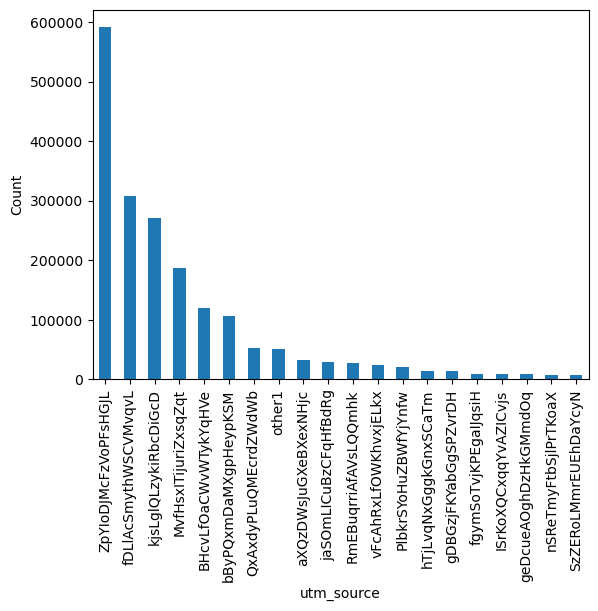

In [255]:
df['utm_source'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='utm_source', ylabel='Count', rot=90)

In [253]:
columns_utm_source_for_save = ['ZpYIoDJMcFzVoPFsHGJL',
 'fDLlAcSmythWSCVMvqvL',
 'kjsLglQLzykiRbcDiGcD',
 'MvfHsxITijuriZxsqZqt',
 'BHcvLfOaCWvWTykYqHVe',
 'bByPQxmDaMXgpHeypKSM',
 'QxAxdyPLuQMEcrdZWdWb',
 'aXQzDWsJuGXeBXexNHjc',
 'jaSOmLICuBzCFqHfBdRg',
 'RmEBuqrriAfAVsLQQmhk',
 'vFcAhRxLfOWKhvxjELkx',
 'PlbkrSYoHuZBWfYjYnfw',
 'hTjLvqNxGggkGnxSCaTm',
 'gDBGzjFKYabGgSPZvrDH',
 'fgymSoTvjKPEgaIJqsiH',
 'ISrKoXQCxqqYvAZICvjs',
 'geDcueAOghDzHkGMmdOq',
 'nSReTmyFtbSjlPrTKoaX',
 'SzZERoLMmrEUEhDaYcyN',
 'eLzNJHzPelJpEyBwMrKo']

In [254]:
df.utm_source = df.utm_source.apply(lambda x: x if x in columns_utm_source_for_save else 'other1')

#### utm_medium

In [256]:
df.utm_medium.value_counts(normalize=True, dropna=False).mul(100).round(2).head(20)

utm_medium
banner             29.74
cpc                23.35
(none)             16.21
cpm                12.80
referral            8.33
organic             3.40
email               1.56
push                1.52
stories             0.56
blogger_channel     0.43
cpv                 0.42
smartbanner         0.37
cpa                 0.23
blogger_stories     0.23
tg                  0.21
app                 0.15
post                0.12
smm                 0.11
outlook             0.07
clicks              0.05
Name: proportion, dtype: float64

<Axes: xlabel='utm_medium', ylabel='Count'>

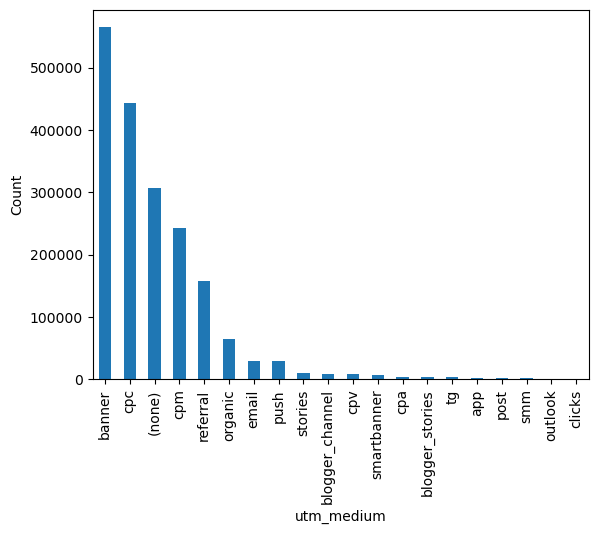

In [257]:
df['utm_medium'].value_counts(dropna=False).head(20).plot(kind='bar', xlabel='utm_medium', ylabel='Count', rot=90)

In [259]:
df.utm_medium.value_counts(normalize=True, dropna=False).head(10).index.tolist()

['banner',
 'cpc',
 '(none)',
 'cpm',
 'referral',
 'organic',
 'email',
 'push',
 'stories',
 'blogger_channel']

In [261]:
columns_utm_medium_for_save = ['banner',
 'cpc',
 '(none)',
 'cpm',
 'referral',
 'organic',
 'email',
 'push',
 'stories',
 'blogger_channel']

In [262]:
df.utm_medium = df.utm_medium.apply(lambda x: x if x in columns_utm_medium_for_save else 'other1')

In [263]:
#Save the result
df.to_csv('../data/df_prepared.csv', index=False)